**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_1_)    
  - [Import packages](#toc1_2_)    
  - [Import datsets](#toc1_3_)    
  - [Data Preparation: Drop Columns over 50% missing values](#toc1_4_)    
  - [Data Preparation: Impute Missing values by imputer](#toc1_5_)    
    - [Object variables](#toc1_5_1_)    
    - [Number(Float64) variables](#toc1_5_2_)    
  - [Data Preparation: Encoding the categorical variables](#toc1_6_)    
      - [Label Encoding](#toc1_6_1_1_)    
      - [One-Hot Encoding](#toc1_6_1_2_)    
  - [Model Process: Model predictors & target assignment](#toc1_7_)    
  - [Model Process: Train & Validation dataset split](#toc1_8_)    
  - [Model Process: Model selection & Comparison](#toc1_9_)    
    - [Decision Tree](#toc1_9_1_)    
    - [Logistic Regression](#toc1_9_2_)    
    - [Random Forest](#toc1_9_3_)    
    - [Naive Baysian](#toc1_9_4_)    
    - [xgboost](#toc1_9_5_)    
  - [Model Performance (Evaluation)](#toc1_10_)    
    - [The AUC Score](#toc1_10_1_)    
    - [Single Score metrics](#toc1_10_2_)    
    - [Cross Validation](#toc1_10_3_)    
  - [Result: Test Submission](#toc1_11_)    
  - [Result: Kaggle Score and Rank](#toc1_12_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introduction](#toc0_)

This notebook is built to generate multiple predictive models and compare the models' performance based on AUC score to obtain the maximum AUC score.

- Project Goal: Project's goal is to predict the target variables and obtain the highest AUC scores using `TEST` dataset.
- Business Problem: Project is dedicated to establish stable & controllable financial system for Home Credit to identify credible candidates by utiltizing the given datasets.
- Analytic Problem: This project makes use of supervised approach with classification model to predict which application has a repayment abilities based on the previous application histories.

## <a id='toc1_2_'></a>[Import packages](#toc0_)

In [54]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%matplotlib inline

## <a id='toc1_3_'></a>[Import datasets](#toc0_)

In [2]:
# import train & test datasets
train = pd.read_csv('/Users/imdongchan/Documents/GitHub/MSBA/CapstoneProject/data/raw/application_train.csv', header = 0, sep = ',', index_col= 0)
test = pd.read_csv('/Users/imdongchan/Documents/GitHub/MSBA/CapstoneProject/data/raw/application_test.csv', header = 0, sep = ',', index_col= 0)

In [3]:
train.shape, test.shape

((307511, 121), (48744, 120))

## <a id='toc1_4_'></a>[Data Preparation: Drop Columns over 50% missing values](#toc0_)

In [4]:
temp = (train.isnull().sum() / len(train) * 100).sort_values(ascending= False)

train_missing_df = pd.DataFrame({'Column':temp.index, 'Prop':temp.values})
columns_to_drop = train_missing_df.loc[train_missing_df.Prop > 50, 'Column'].to_list()
columns_to_drop

['COMMONAREA_AVG',
 'COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MODE',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_MODE',
 'OWN_CAR_AGE',
 'LANDAREA_MEDI',
 'LANDAREA_AVG',
 'LANDAREA_MODE',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MODE',
 'EXT_SOURCE_1',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_MEDI',
 'ELEVATORS_MODE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'WALLSMATERIAL_MODE',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'LIVINGAREA_AVG',
 'HOUSETYPE_MODE']

In [5]:
# drop the columns over 50% missing values
train.drop(columns = columns_to_drop, axis= 1, inplace= True)
test.drop(columns = columns_to_drop, axis= 1, inplace= True)

In [6]:
train.shape, test.shape

((307511, 80), (48744, 79))

In [7]:
temp = (train.isnull().sum() / len(train) * 100).sort_values(ascending= False)

train_missing_df = pd.DataFrame({'Column':temp.index, 'Prop':temp.values})
train_missing_df.head(20)

,Column,Prop
0,FLOORSMAX_MEDI,49.760822
1,FLOORSMAX_MODE,49.760822
2,FLOORSMAX_AVG,49.760822
3,YEARS_BEGINEXPLUATATION_MEDI,48.781019
4,YEARS_BEGINEXPLUATATION_MODE,48.781019
5,YEARS_BEGINEXPLUATATION_AVG,48.781019
6,TOTALAREA_MODE,48.268517
7,EMERGENCYSTATE_MODE,47.398304
8,OCCUPATION_TYPE,31.345545
9,EXT_SOURCE_3,19.825307


In [8]:
temp = (test.isnull().sum() / len(test) * 100).sort_values(ascending= False)

test_missing_df = pd.DataFrame({'Column':temp.index, 'Prop':temp.values})
test_missing_df.head(20)

,Column,Prop
0,FLOORSMAX_MEDI,47.843837
1,FLOORSMAX_MODE,47.843837
2,FLOORSMAX_AVG,47.843837
3,YEARS_BEGINEXPLUATATION_MEDI,46.889874
4,YEARS_BEGINEXPLUATATION_MODE,46.889874
5,YEARS_BEGINEXPLUATATION_AVG,46.889874
6,TOTALAREA_MODE,46.413918
7,EMERGENCYSTATE_MODE,45.562531
8,OCCUPATION_TYPE,32.014197
9,EXT_SOURCE_3,17.782701


## <a id='toc1_5_'></a>[Data Preparation: Impute Missing values by imputer](#toc0_)

### <a id='toc1_5_1_'></a>[Object variables](#toc0_)

- we can utilize `SimpleImputer` class to impute the most frequent value in the categorical variables.


In [9]:
# get categorical variable list with missing values
object_columns = train.select_dtypes(include='object').columns
object_impute_df = train[object_columns].isnull().any(axis=0)
object_impute_col = object_impute_df[object_impute_df.values == True].index.to_list()
object_impute_col

['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE']

### <a id='toc1_5_2_'></a>[Number(Float64) variables](#toc0_)

- we can utilize `SimpleImputer` class to impute the median value in the numeric variables.

In [10]:
# get numerical variable list with missing values
number_columns = train.select_dtypes(include='number').columns
number_impute_df = train[number_columns].isnull().any(axis=0)
number_impute_col = number_impute_df[number_impute_df.values == True].index.to_list()
number_impute_col

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLOORSMAX_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [11]:
imp_cat_freq = SimpleImputer(strategy="most_frequent")
imp_num_median = SimpleImputer(missing_values= np.nan, strategy="median")

train[object_impute_col] = imp_cat_freq.fit_transform(train[object_impute_col])
train[number_impute_col] = imp_num_median.fit_transform(train[number_impute_col])

test[object_impute_col] = imp_cat_freq.transform(test[object_impute_col])
test[number_impute_col] = imp_num_median.transform(test[number_impute_col])


In [12]:
train.isnull().sum()

TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 80, dtype: int64

In [13]:
test.isnull().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 79, dtype: int64

## <a id='toc1_6_'></a>[Data Preparation: Encoding the categorical variables](#toc0_)

There are two methodolgies to encode the categorical variables as numeric values.
- Label Encoding
- One-hot Encoding

#### <a id='toc1_6_1_1_'></a>[Label Encoding](#toc0_)

In [14]:
# Iterate through the columns
def label_encoding(train, test):
    le = LabelEncoder()
    le_count = 0
    for col in train:
        if train[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(train[col].unique())) <= 2:
                # Train on the training data
                le.fit(train[col])
                # Transform both training and testing data
                train[col] = le.transform(train[col])
                test[col] = le.transform(test[col])
            
                # Keep track of how many columns were label encoded
                le_count += 1           
    print('%d columns were label encoded.' % le_count)

label_encoding(train, test)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

4 columns were label encoded.
Training Features shape:  (307511, 80)
Testing Features shape:  (48744, 79)


#### <a id='toc1_6_1_2_'></a>[One-Hot Encoding](#toc0_)

In [15]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 189)
Testing Features shape:  (48744, 185)


In [16]:
# check which variable doesn't exist within the test dataset
list(set(train.columns) - set(test.columns))

['TARGET',
 'NAME_INCOME_TYPE_Maternity leave',
 'CODE_GENDER_XNA',
 'NAME_FAMILY_STATUS_Unknown']

In [17]:
train['NAME_FAMILY_STATUS_Unknown'].sum()

2

In [18]:
train['NAME_INCOME_TYPE_Maternity leave'].sum()

5

In [19]:
train['CODE_GENDER_XNA'].sum()

4

In [20]:
train.drop(columns= ['NAME_FAMILY_STATUS_Unknown',
 'NAME_INCOME_TYPE_Maternity leave',
 'CODE_GENDER_XNA'], inplace= True)

In [21]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 186)
Testing Features shape:  (48744, 185)


## <a id='toc1_7_'></a>[Model Process: Model predictors & target assignment](#toc0_)

In [22]:
X= train.drop(columns=['TARGET'])
y= train['TARGET']

## <a id='toc1_8_'></a>[Model Process: Train & Validation dataset split](#toc0_)

In [23]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=.30, random_state= 42)

In [24]:
print("X train's shape: ", x_train.shape)
print("y train's shape: ", y_train.shape)
print("X valid's shape: ", x_valid.shape)
print("y valid's shape: ", y_valid.shape)

X train's shape:  (215257, 185)
y train's shape:  (215257,)
X valid's shape:  (92254, 185)
y valid's shape:  (92254,)


## <a id='toc1_9_'></a>[Model Process: Model selection & Comparison](#toc0_)

### <a id='toc1_9_1_'></a>[Decision Tree](#toc0_)

In [25]:
%%time

dcn_tree = DecisionTreeClassifier(max_depth= 5)

# Train on the training data
dcn_tree.fit(x_train, y_train)

CPU times: user 1.64 s, sys: 61.4 ms, total: 1.7 s
Wall time: 1.81 s


DecisionTreeClassifier(max_depth=5)

### <a id='toc1_9_2_'></a>[Logistic Regression](#toc0_)

In [26]:
%%time

log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(x_train, y_train)

CPU times: user 37.9 s, sys: 1.01 s, total: 38.9 s
Wall time: 7.29 s


LogisticRegression(C=0.0001)

### <a id='toc1_9_3_'></a>[Random Forest](#toc0_)

In [27]:
%%time

rforest = RandomForestClassifier(random_state=42)

# Train on the training data
rforest.fit(x_train, y_train)

CPU times: user 43.5 s, sys: 246 ms, total: 43.8 s
Wall time: 43.9 s


RandomForestClassifier(random_state=42)

### <a id='toc1_9_4_'></a>[Naive Baysian](#toc0_)

In [28]:
%%time

nb = GaussianNB()

# Train on the training data
nb.fit(x_train, y_train)

CPU times: user 212 ms, sys: 356 ms, total: 568 ms
Wall time: 818 ms


GaussianNB()

### <a id='toc1_9_5_'></a>[xgboost](#toc0_)

In [74]:
%%time

xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train on the training data
xgb.fit(x_train, y_train)

CPU times: user 12.6 s, sys: 2.27 s, total: 14.8 s
Wall time: 3.67 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## <a id='toc1_10_'></a>[Model Performance (Evaluation)](#toc0_)

### <a id='toc1_10_1_'></a>[The AUC Score](#toc0_)

- The AUC score, or Area Under the Receiver Operating Characteristic (ROC) Curve, is a performance measurement for classification prediction. 
- The AUC score represents the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.
- The AUC score is useful when dealing with imbalanced datasets because the AUC score is not affected by the proportion of the positive and negative classes.

### <a id='toc1_10_2_'></a>[Single Score metrics](#toc0_)

In [30]:
def eval_model_auc(model):
    # Predict the probabilities for the positive class
    y_pred_proba = model.predict_proba(x_valid)[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(y_valid, y_pred_proba)

    print(f"{model}'s AUC Score: {auc_score}")

In [31]:
%%time

for m in [dcn_tree, log_reg, rforest, nb, xgb]:
    eval_model_auc(m)

DecisionTreeClassifier(max_depth=5)'s AUC Score: 0.7077005932903115
LogisticRegression(C=0.0001)'s AUC Score: 0.6185323981338209
RandomForestClassifier(random_state=42)'s AUC Score: 0.7063138299219536
GaussianNB()'s AUC Score: 0.6126112770030889
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...

### <a id='toc1_10_3_'></a>[Cross Validation](#toc0_)

In [86]:
model_dict = {'decision tree': dcn_tree,
              'logistic regression': log_reg,
              'random forest': rforest,
              'naive bayesian': nb,
              'xgboost':xgb}

In [35]:

def cross_valid5_score(model):
    scores = cross_validate(model, X, y, cv=5,
                        scoring= 'roc_auc',
                        return_train_score=True)
    return scores['test_score'].mean()

In [40]:
for name, model in model_dict.items():
    print(f"{name}: {cross_valid5_score(model)}")

decision tree: 0.7065853705162585
logistic regression: 0.6202837874011871
random forest: 0.7098714103604041
naive beysian: 0.6030178488340501
xgboost: 0.7452102395487324


XGB (xgboost) has the highest AUC score among the multiple classifier models (decision tree, logistic regression, random forest, naive beysian, xgboost)

In [41]:
def plot_roc_curve(model):
    # Predict the probabilities for the positive class
    y_pred_proba = model.predict_proba(x_valid)[:, 1]
    # Calculate the AUC score
    auc_score = roc_auc_score(y_valid, y_pred_proba)    
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


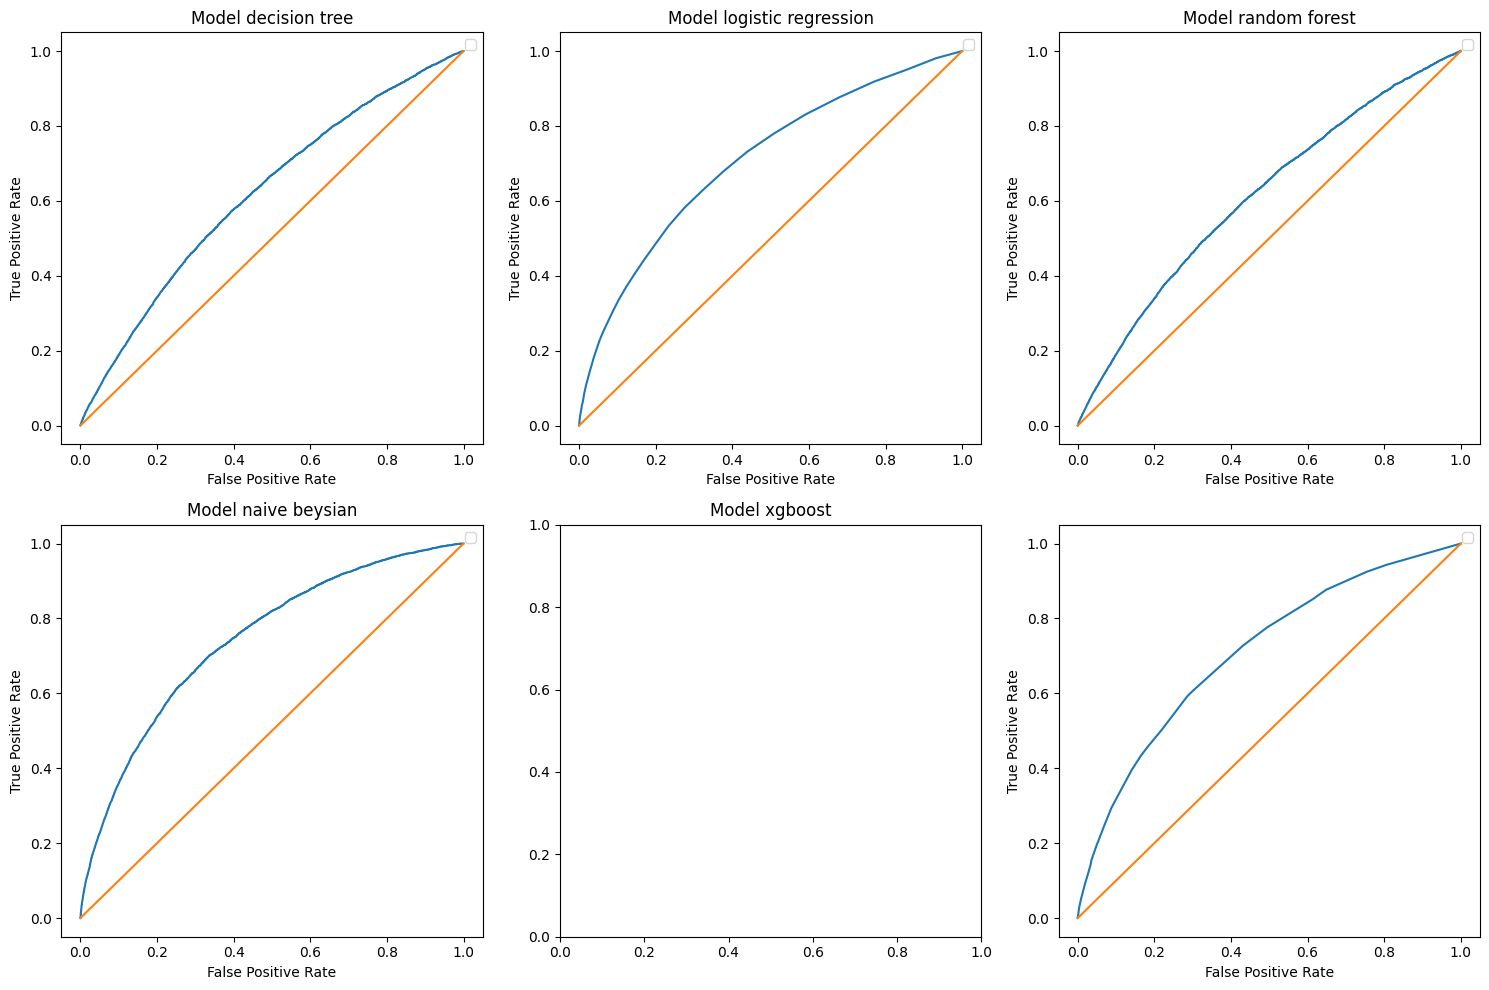

In [70]:
models = model_dict.values()
mname = list(model_dict.keys())

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, model in enumerate(models):
    plot_roc_curve(model)
    plt.plot([0,1],[0,1],label='STR')
    plt.sca(axs[i])
    plt.title(f"Model {mname[i]}")

plt.tight_layout()
plt.show()

## Feature Importance

In [79]:
f_importance = xgb.feature_importances_
pd.Series(f_importance, index = x_train.columns).sort_values(ascending= False)

EXT_SOURCE_3                          0.029133
EXT_SOURCE_2                          0.024752
CODE_GENDER_M                         0.023071
CODE_GENDER_F                         0.020657
FLAG_DOCUMENT_3                       0.017890
                                        ...   
ORGANIZATION_TYPE_Industry: type 6    0.000000
OCCUPATION_TYPE_Realty agents         0.000000
ORGANIZATION_TYPE_Emergency           0.000000
ORGANIZATION_TYPE_Culture             0.000000
ORGANIZATION_TYPE_XNA                 0.000000
Length: 185, dtype: float32

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

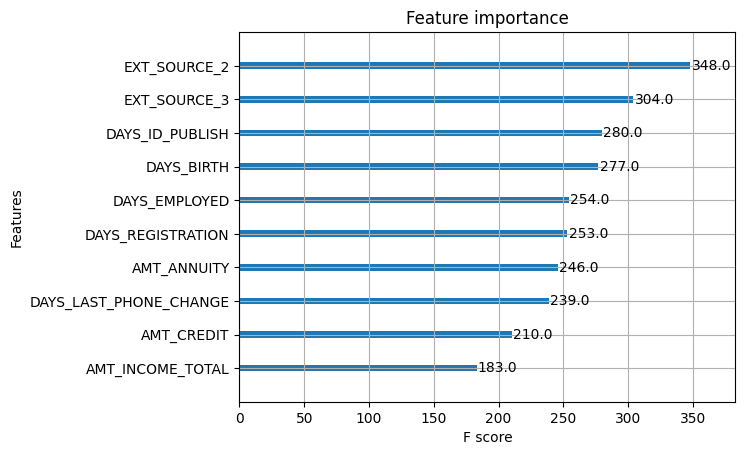

In [87]:
plot_importance(xgb, max_num_features= 10)

## <a id='toc1_11_'></a>[Result: Test Submission](#toc0_)

In [90]:
# Train on the test data
y_pred_proba = xgb.predict_proba(test)[:, 1]

In [95]:
submit = test.reset_index()[['SK_ID_CURR']]
submit['TARGET'] = y_pred_proba

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.021029
1,100005,0.169418
2,100013,0.022782
3,100028,0.068133
4,100038,0.138050


In [96]:
submit.to_csv('submission.csv', index = False)

## <a id='toc1_12_'></a>[Result: Kaggle Score and Rank](#toc0_)

- Private Score: 0.72335
- Public Score: 0.72696